In [24]:
# packages

import importlib_resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from itertools import combinations
import xlrd
from matplotlib.patches import Ellipse
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import zscore

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

import os
os.chdir(os.path.abspath(''))

In [18]:
filename = 'Raisin_Dataset.xls'
doc = xlrd.open_workbook(filename).sheet_by_index(0)


attributeNames = doc.row_values(0, 0, 7)

classLabels = doc.col_values(7, 1, 901)
classNames = sorted(set(classLabels))
classDict = dict(zip(classNames, range(len(classNames))))

# Extract vector y, convert to NumPy array
y = np.asarray([classDict[value] for value in classLabels])

# Preallocate memory, then extract excel data to matrix X
X = np.empty((900, 7))
for i, col_id in enumerate(range(0, 7)):
    X[:, i] = np.asarray(doc.col_values(col_id, 1, 901))

# Compute values of N, M and C
N = len(y)
M = len(attributeNames)
C = len(classNames)

print(f'matrix size: {N} by {M}')
print(attributeNames)
print(classNames)


matrix size: 900 by 7
['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']
['Besni', 'Kecimen']


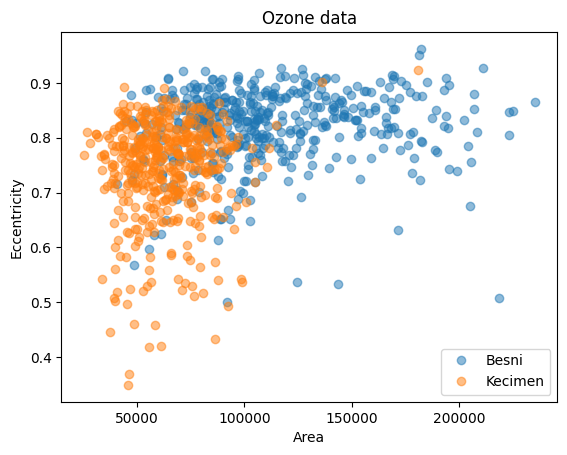

In [19]:
# from ex 2_1_2

i = 0
j = 3

f = plt.figure()
plt.title("Ozone data")

for c in range(C):
    # select indices belonging to class c:
    class_mask = y == c
    plt.plot(X[class_mask, i], X[class_mask, j], "o", alpha=0.5)

plt.legend(classNames)
plt.xlabel(attributeNames[i])
plt.ylabel(attributeNames[j])
plt.show()

outer cross validation fold 1/10
outer cross validation fold 2/10
outer cross validation fold 3/10
outer cross validation fold 4/10
outer cross validation fold 5/10
outer cross validation fold 6/10
outer cross validation fold 7/10
outer cross validation fold 8/10
outer cross validation fold 9/10
outer cross validation fold 10/10


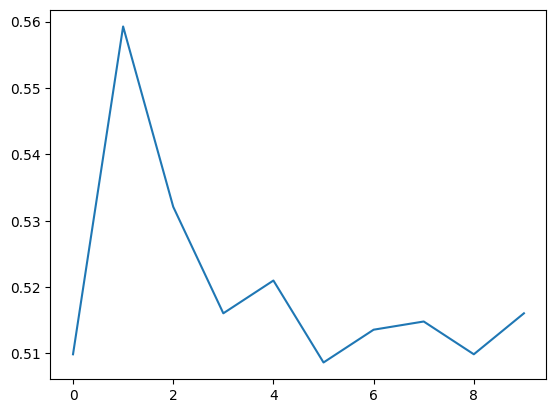

In [22]:
# only baseline

K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)

# outer fold
E_baseline = np.zeros(K)


k1=0
for train_index1, test_index1 in CV.split(X):
    
    # extract training and test set
    X_train1 = X[train_index1,:]
    y_train1 = y[train_index1]
    X_test1 = X[test_index1,:]
    y_test1 = y[test_index1]

    # standardize the training set
    mu = np.mean(X_train1, 0)
    sigma = np.std(X_train1, 0)
    X_train1 = (X_train1 - mu) / sigma
    X_test1 = (X_test1 - mu) / sigma

    N_train1 = len(train_index1)
    N_test1 = len(test_index1)

    E_baseline_inner = np.zeros(K)
    
    k2 = 0
    for train_index2, test_index2 in CV.split(X_train1):
        X_train2 = X_train1[train_index2,:]
        y_train2 = y_train1[train_index2]
        X_test2 =  X_train1[test_index2,:]
        y_test2 =  y_train1[test_index2]

        N_train2 = len(train_index2)
        N_test2 = len(test_index2)

        # MODEL 3: BASE MODEL
        base_class = np.sum(y_train2)/ N_train2
        if base_class > 0.5:
            y_est = np.ones(N_test2)
        else:
            y_est = np.zeros(N_test2)
        
        error_test = np.sum(y_est!=y_test2)/N_test2
        E_baseline_inner[k2] = error_test


        # print(f'inner cross validation fold {k2+1}/{K}')
        k2+=1
    
    # generalized error for outer fold k1
    E_baseline[k1] = np.sum(E_baseline_inner)/K


    print(f'outer cross validation fold {k1+1}/{K}')
    k1+=1

plt.plot(range(K), E_baseline)


plt.show()

outer cross validation fold 1/10
outer cross validation fold 2/10
outer cross validation fold 3/10
outer cross validation fold 4/10
outer cross validation fold 5/10
outer cross validation fold 6/10
outer cross validation fold 7/10
outer cross validation fold 8/10
outer cross validation fold 9/10
outer cross validation fold 10/10


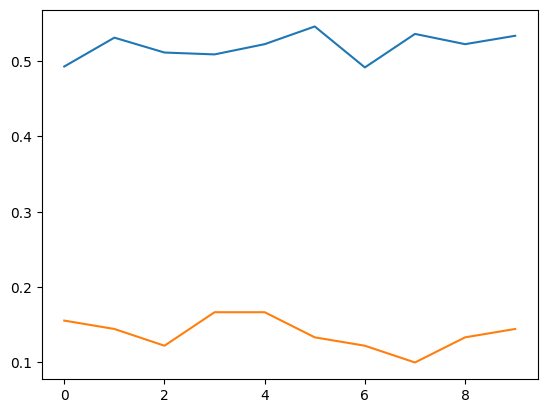

In [31]:
# baseline + regression

K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)

# outer fold
E_baseline = np.zeros(K)


E_logistic = np.zeros(K)
lambda_interval = np.logspace(-8, 2, 50)
lambda_array = np.zeros(K)


k1=0
for train_index1, test_index1 in CV.split(X):
    
    # extract training and test set
    X_train1 = X[train_index1,:]
    y_train1 = y[train_index1]
    X_test1 = X[test_index1,:]
    y_test1 = y[test_index1]

    # standardize the training set
    mu = np.mean(X_train1, 0)
    sigma = np.std(X_train1, 0)
    X_train1 = (X_train1 - mu) / sigma
    X_test1 = (X_test1 - mu) / sigma

    N_train1 = len(train_index1)
    N_test1 = len(test_index1)

    E_baseline_inner = np.zeros(K)

    E_logistic_inner = np.zeros((K,len(lambda_interval)))
    
    k2 = 0
    for train_index2, test_index2 in CV.split(X_train1):
        X_train2 = X_train1[train_index2,:]
        y_train2 = y_train1[train_index2]
        X_test2 =  X_train1[test_index2,:]
        y_test2 =  y_train1[test_index2]

        N_train2 = len(train_index2)
        N_test2 = len(test_index2)

        # MODEL 3: BASE MODEL
        base_class = np.sum(y_train2)/ N_train2
        if base_class > 0.5:
            y_est = np.ones(N_test2)
        else:
            y_est = np.zeros(N_test2)
        
        error_test = np.sum(y_est!=y_test2)/N_test2
        E_baseline_inner[k2] = error_test


        # MODEL 1: LOGISTIC REGRESSION
        # from ex8_1_2
        
        # select optimal model
        test_error_rate = np.zeros(len(lambda_interval))

        for iteration in range(0, len(lambda_interval)):
            mdl = LogisticRegression(penalty="l2", C=1 / lambda_interval[iteration])
            mdl.fit(X_train2, y_train2)

            y_test_est = mdl.predict(X_test2).T
            #test_error_rate[iteration] = np.sum(y_test_est != y_test2) / N_test2
            E_logistic_inner[k2, iteration] = np.sum(y_test_est != y_test2) / N_test2

        #min_error = np.min(test_error_rate)
        #opt_lambda_idx = np.argmin(test_error_rate)
        #opt_lambda = lambda_interval[opt_lambda_idx]

        # print(f'inner cross validation fold {k2+1}/{K}')
        k2+=1
    
    # baseline
    E_baseline[k1] = np.sum(E_baseline_inner)/K


    # logistic regression
    # evaluate optimal model
    min_error = np.min(np.sum(E_logistic_inner, axis=0))
    opt_lambda_idx = np.argmin(np.sum(E_logistic_inner, axis=0))
    opt_lambda = lambda_interval[opt_lambda_idx]
    lambda_array[k1] = opt_lambda

    # compute error of optimal model
    mdl = LogisticRegression(penalty="l2", C=1 / opt_lambda)
    mdl.fit(X_train1, y_train1)
    y_test_est = mdl.predict(X_test1).T
    test_error_rate = np.sum(y_test_est != y_test1) / N_test1
    E_logistic[k1] = test_error_rate



    print(f'outer cross validation fold {k1+1}/{K}')
    k1+=1


plt.plot(range(K), E_baseline)
plt.plot(range(K), E_logistic)


plt.show()

In [29]:
A = [[1,2,3],[4,5,6],[7,8,9]]
A = np.matrix(A)

print(A)
print(np.sum(A, axis=0))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[12 15 18]]
